In [1]:
from itertools import chain

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout
from tensorflow.keras.layers import LSTM, Softmax
from tensorflow.keras.losses import Hinge, SquaredHinge

In [2]:
# Hyperparams

# Note: Window size needs to be at least 4 for kurtosis to work
WINDOW_SIZE = 4
NUM_INPUTS = 16
NUM_CLASSES = 3

In [3]:
data = pd.read_csv("daily_eur_usd.csv").iloc[::-1].reset_index(drop=True)

In [4]:
data

,date,open,high,low,close
0,2002-01-28,0.8630,0.8663,0.8567,0.8610
1,2002-01-29,0.8611,0.8656,0.8587,0.8644
2,2002-01-30,0.8642,0.8674,0.8597,0.8614
3,2002-01-31,0.8613,0.8646,0.8575,0.8579
4,2002-02-01,0.8586,0.8642,0.8560,0.8614
...,...,...,...,...,...
4995,2021-03-23,1.1934,1.1941,1.1840,1.1849
4996,2021-03-24,1.1849,1.1852,1.1808,1.1812
4997,2021-03-25,1.1812,1.1828,1.1760,1.1768
4998,2021-03-26,1.1768,1.1805,1.1766,1.1793


In [5]:
# Use only open prices for now
# data.drop(columns=["high", "low", "close"], inplace=True)

In [6]:
open_skew = data.rolling(window=WINDOW_SIZE).skew(axis=1).rename(columns={
    "open": "rolling_open_skew",
    "high": "rolling_high_skew",
    "low": "rolling_low_skew",
    "close": "rolling_close_skew",
})
open_skew

,rolling_open_skew
0,NaN
1,NaN
2,NaN
3,0.526770
4,0.260613
...,...
4995,0.449674
4996,-0.271693
4997,0.430127
4998,0.768187


In [7]:
open_kurt = data.rolling(window=WINDOW_SIZE).kurt(axis=1).rename(columns={
    "open": "rolling_open_kurtosis",
    "high": "rolling_high_kurtosis",
    "low": "rolling_low_kurtosis",
    "close": "rolling_close_kurtosis",
})
open_kurt

,rolling_open_kurtosis
0,NaN
1,NaN
2,NaN
3,-2.886462
4,1.500000
...,...
4995,0.340311
4996,-1.657251
4997,-0.044676
4998,0.628257


In [8]:
open_dev = data.rolling(window=WINDOW_SIZE).std().rename(columns={
    "open": "rolling_open_std",
    "high": "rolling_high_std",
    "low": "rolling_low_std",
    "close": "rolling_close_std",
})
open_dev

,rolling_open_std
0,NaN
1,NaN
2,NaN
3,0.001472
4,0.002291
...,...
4995,0.004200
4996,0.003717
4997,0.005162
4998,0.007043


In [9]:
data2 = pd.concat([data, open_skew, open_kurt, open_dev], axis=1)
data2

,date,open,rolling_open_skew,rolling_open_kurtosis,rolling_open_std
0,2002-01-28,0.8630,NaN,NaN,NaN
1,2002-01-29,0.8611,NaN,NaN,NaN
2,2002-01-30,0.8642,NaN,NaN,NaN
3,2002-01-31,0.8613,0.526770,-2.886462,0.001472
4,2002-02-01,0.8586,0.260613,1.500000,0.002291
...,...,...,...,...,...
4995,2021-03-23,1.1934,0.449674,0.340311,0.004200
4996,2021-03-24,1.1849,-0.271693,-1.657251,0.003717
4997,2021-03-25,1.1812,0.430127,-0.044676,0.005162
4998,2021-03-26,1.1768,0.768187,0.628257,0.007043


In [10]:
data["open"].pct_change().max()

0.03795620437956204

In [11]:
def iterate_pairs(df, f):
    memory = None
    for idx, row in df.iterrows():
        item = row["open"]
        yield f(memory, item)
        memory = item

In [12]:
# Test/Debug purposes only
def simple(old, new):
    if old is None:
        return None
    return old - new

test_df = pd.DataFrame(list(iterate_pairs(data, simple)), columns=["Test"])
test_df

,Test
0,NaN
1,0.0019
2,-0.0031
3,0.0029
4,0.0027
...,...
4995,-0.0054
4996,0.0085
4997,0.0037
4998,0.0044


In [13]:
def decide_buy_sell(old, new):
    if old is None:
        return 0
    if abs(old - new) < 0.001:
        return 0
    if old < new:
        return -1
    if new < old:
        return 1
    
buy_sell_df = pd.DataFrame(list(iterate_pairs(data, decide_buy_sell)), columns=["buy/sell"])
buy_sell_df

,buy/sell
0,0
1,1
2,-1
3,1
4,1
...,...
4995,-1
4996,1
4997,1
4998,1


In [14]:
display = pd.concat([data, buy_sell_df], axis=1)
display

,date,open,buy/sell
0,2002-01-28,0.8630,0
1,2002-01-29,0.8611,1
2,2002-01-30,0.8642,-1
3,2002-01-31,0.8613,1
4,2002-02-01,0.8586,1
...,...,...,...
4995,2021-03-23,1.1934,-1
4996,2021-03-24,1.1849,1
4997,2021-03-25,1.1812,1
4998,2021-03-26,1.1768,1


In [15]:
# Get the longest consecutive "same decision"
holder = buy_sell_df.copy(deep=True)
holder["indicator"] = buy_sell_df["buy/sell"].diff().ne(0).cumsum()

sizes=holder.groupby('indicator')['buy/sell'].transform('size')
display[sizes == sizes.max()]

,date,open,buy/sell
3854,2016-11-07,1.1084,1
3855,2016-11-08,1.1043,1
3856,2016-11-09,1.1013,1
3857,2016-11-10,1.0920,1
3858,2016-11-11,1.0886,1
3859,2016-11-14,1.0838,1
3860,2016-11-15,1.0744,1
3861,2016-11-16,1.0724,1
3862,2016-11-17,1.0699,1
3863,2016-11-18,1.0626,1


In [16]:
# Time to build a model; we want to predict our buy/sell choices from above
X, Y = data2.drop(columns=["date"]), buy_sell_df["buy/sell"]

In [17]:
X

,open,rolling_open_skew,rolling_open_kurtosis,rolling_open_std
0,0.8630,NaN,NaN,NaN
1,0.8611,NaN,NaN,NaN
2,0.8642,NaN,NaN,NaN
3,0.8613,0.526770,-2.886462,0.001472
4,0.8586,0.260613,1.500000,0.002291
...,...,...,...,...
4995,1.1934,0.449674,0.340311,0.004200
4996,1.1849,-0.271693,-1.657251,0.003717
4997,1.1812,0.430127,-0.044676,0.005162
4998,1.1768,0.768187,0.628257,0.007043


In [18]:
Y

0       0
1       1
2      -1
3       1
4       1
       ..
4995   -1
4996    1
4997    1
4998    1
4999   -1
Name: buy/sell, Length: 5000, dtype: int64

In [19]:
# Make rolling window inputs
def prepare_inputs(X):
    def make_rolling_window_inputs(df):
        cnt = 0
        for x in df.rolling(window=WINDOW_SIZE):
            cnt += 1
            if cnt < WINDOW_SIZE:
                continue
            yield pd.array(list(chain.from_iterable(x.values)))

    # Arcane wizardry from: https://stackoverflow.com/questions/55126339/how-to-flatten-array-in-pandas-dataframe
    out = pd.Series(list(chain.from_iterable(make_rolling_window_inputs(X)))).fillna(float('NaN'))
    return out.values.reshape(len(out) // (WINDOW_SIZE * NUM_INPUTS), NUM_INPUTS, WINDOW_SIZE)
final_out = np.asarray(prepare_inputs(X)).astype('float32')
final_out

array([[[ 8.6299998e-01,            nan,            nan,            nan],
        [ 8.6110002e-01,            nan,            nan,            nan],
        [ 8.6420000e-01,            nan,            nan,            nan],
        [ 8.6129999e-01,  5.2677011e-01, -2.8864617e+00,  1.4719601e-03]],

       [[ 8.6110002e-01,            nan,            nan,            nan],
        [ 8.6420000e-01,            nan,            nan,            nan],
        [ 8.6129999e-01,  5.2677011e-01, -2.8864617e+00,  1.4719601e-03],
        [ 8.5860002e-01,  2.6061329e-01,  1.5000001e+00,  2.2905604e-03]],

       [[ 8.6420000e-01,            nan,            nan,            nan],
        [ 8.6129999e-01,  5.2677011e-01, -2.8864617e+00,  1.4719601e-03],
        [ 8.5860002e-01,  2.6061329e-01,  1.5000001e+00,  2.2905604e-03],
        [ 8.6199999e-01, -3.1365895e-01,  1.1074040e+00,  2.3084988e-03]],

       ...,

       [[ 1.1880000e+00,  1.4343964e+00,  2.4699903e+00,  4.3254094e-03],
        [ 1.1934000

In [20]:
final_out.shape

(4997, 4, 4)

In [21]:
final_out[3]

array([[ 8.6129999e-01,  5.2677011e-01, -2.8864617e+00,  1.4719601e-03],
       [ 8.5860002e-01,  2.6061329e-01,  1.5000001e+00,  2.2905604e-03],
       [ 8.6199999e-01, -3.1365895e-01,  1.1074040e+00,  2.3084988e-03],
       [ 8.6989999e-01,  1.4407963e+00,  2.6328781e+00,  4.8596980e-03]],
      dtype=float32)

In [22]:
def make_onehot(idx):
    res = np.zeros(NUM_CLASSES)
    res[idx] = 1
    return res

# Make it range from [0,3] rather than [-1,1]
final_labels = Y.add(1)
final_labels = final_labels.apply(lambda x: make_onehot(x))
final_labels = pd.array(list(chain.from_iterable(final_labels.values)))


0       1
1       2
2       0
3       2
4       2
       ..
4995    0
4996    2
4997    2
4998    2
4999    0
Name: buy/sell, Length: 5000, dtype: int64

In [23]:
final_out[-1:]

array([[[ 1.1849    , -0.2716931 , -1.6572506 ,  0.00371697],
        [ 1.1812    ,  0.4301266 , -0.04467627,  0.00516228],
        [ 1.1768    ,  0.76818657,  0.6282569 ,  0.00704338],
        [ 1.1787    ,  0.6232748 , -0.4586501 ,  0.00349952]]],
      dtype=float32)

In [24]:
final_labels = np.asarray(final_labels).astype('float32').reshape(len(final_labels) // (NUM_CLASSES), NUM_CLASSES)

0    2176
2    2061
1     763
Name: buy/sell, dtype: int64

In [27]:
# Had some nan loss issues (I think exploding gradients)
# Some useful tips: https://datascience.stackexchange.com/questions/68331/keras-sequential-model-returns-loss-nan

model = Sequential()
model.add(LSTM(80, activation='relu', kernel_regularizer='l2', input_shape=(NUM_INPUTS,WINDOW_SIZE)))
model.add(Dense(100, activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='relu', kernel_regularizer='l2'))
model.add(Softmax())
model.compile(optimizer='adam', loss=SquaredHinge(), metrics=["accuracy"])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 80)                27200     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               8100      
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 45,501
Trainable params: 45,501
Non-trainable params: 0
__________________________________________________

In [28]:
history = model.fit(final_out[3:], final_labels[6:], epochs=5, validation_split=0.2, batch_size=20)

Epoch 1/50
200/200 [==============================] - 5s 17ms/step - loss: 2.9402 - accuracy: 0.4102 - mse: 1.9197 - binary_crossentropy: 0.6811 - val_loss: 1.8619 - val_accuracy: 0.3924 - val_mse: 1.8358 - val_binary_crossentropy: 0.6931
Epoch 2/50
200/200 [==============================] - 3s 15ms/step - loss: 1.9414 - accuracy: 0.4160 - mse: 1.9305 - binary_crossentropy: 0.6931 - val_loss: 1.8359 - val_accuracy: 0.3924 - val_mse: 1.8358 - val_binary_crossentropy: 0.6931
Epoch 3/50
200/200 [==============================] - 3s 13ms/step - loss: 1.9490 - accuracy: 0.4095 - mse: 1.9490 - binary_crossentropy: 0.6931 - val_loss: 1.8358 - val_accuracy: 0.3924 - val_mse: 1.8358 - val_binary_crossentropy: 0.6931
Epoch 4/50
200/200 [==============================] - 3s 14ms/step - loss: 1.8913 - accuracy: 0.4178 - mse: 1.8913 - binary_crossentropy: 0.6931 - val_loss: 1.8358 - val_accuracy: 0.3924 - val_mse: 1.8358 - val_binary_crossentropy: 0.6931
Epoch 5/50
200/200 [========================

In [29]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'mse', 'binary_crossentropy', 'val_loss', 'val_accuracy', 'val_mse', 'val_binary_crossentropy'])


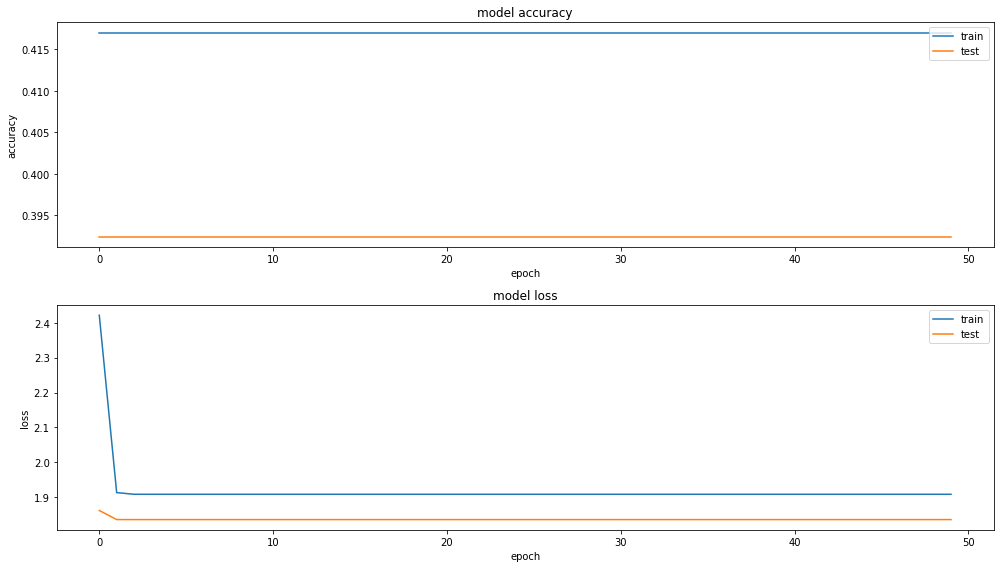

In [30]:
# https://www.codesofinterest.com/2017/03/graph-model-training-history-keras.html

plt.figure(1, figsize=(14,8))

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()
plt.show()

In [31]:
model.predict(final_out[-1:])

array([[1.]], dtype=float32)